<a href="https://colab.research.google.com/github/Kostia9/Data-Analysis-2025/blob/main/Lab4/Lab4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Експерименти з моделями бібліотеки Hugging Face

# a)
Візьміть свій датасет для класифікації текстів (з другої лабораторної роботи).
Використайте модуль pipeline для запуску готових моделей, оберіть мінімум дві моделі.
Прогоніть ваші тексти через обрані моделі та збережіть результати.
Оцініть якість класифікації: accuracy; classification report (precision, recall, F1).
Зробіть висновки: Яка модель дала кращий результат? Порівняйте зі своїми даним з 2 лабораторної роботи.

In [1]:
import os, json
from google.colab import userdata
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.environ["KAGGLE_JSON"] = userdata.get("KAGGLE_JSON")
kaggle_json = os.environ['KAGGLE_JSON']
kaggle_token = json.loads(kaggle_json)
kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")
with open(kaggle_path, "w") as f:
    json.dump(kaggle_token, f)
os.chmod(kaggle_path, 0o600)
!pip install -q kaggle
!kaggle datasets download -d bittlingmayer/amazonreviews
!unzip -n amazonreviews.zip

Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
amazonreviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazonreviews.zip


In [2]:
import bz2
import pandas as pd
import re
import string
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report
import time
import torch
from diffusers import DiffusionPipeline, AutoPipelineForInpainting, AutoPipelineForImage2Image
from diffusers.utils import load_image
from PIL import Image

In [3]:
# --- 2. Load, clean, tokenize ---
def extractData(filename, n_samples=None):
    data = []
    with bz2.open(filename, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if n_samples is not None and i >= n_samples:
                break
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                label, text = parts
                data.append((label, text))
    df = pd.DataFrame(data, columns=['label', 'text'])
    df['label'] = df['label'].str.extract(r'(\d+)').astype(int)
    # Keep only labels {1,2} then map to {0,1}
    df = df[df['label'].isin([1, 2])].reset_index(drop=True)
    df['label'] = df['label'] - 1
    return df

#train_df = extractData('train.ft.txt.bz2', n_samples=200_000)
test_df  = extractData('test.ft.txt.bz2', n_samples=100_000)

print(f"Loaded {len(test_df)} test samples.")

print(test_df.head())

Loaded 100000 test samples.
   label                                               text
0      1  Great CD: My lovely Pat has one of the GREAT v...
1      1  One of the best game music soundtracks - for a...
2      0  Batteries died within a year ...: I bought thi...
3      1  works fine, but Maha Energy is better: Check o...
4      1  Great for the non-audiophile: Reviewed quite a...


In [4]:
# Модель A: DistilBERT (легка, швидка)
pipe_distilbert = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device="cuda", dtype=torch.float16)

# Модель B: BERT-base-uncased (спеціалізована на відгуках IMDb)
pipe_roberta = pipeline("sentiment-analysis", model="textattack/bert-base-uncased-imdb", device="cuda", dtype=torch.float16)

Device set to use cuda
Device set to use cuda


In [5]:
texts = test_df['text'].tolist()
true_labels = test_df['label'].tolist()

In [6]:
print("\nЗапуск DistilBERT...")
start_time_distilbert = time.time()
# DistilBERT повертає структуру: [{'label': 'POSITIVE'/'NEGATIVE', 'score': ...}]
preds_a_raw = pipe_distilbert(texts, truncation=True, max_length=512)
end_time_distilbert = time.time()
print(f"DistilBERT took {end_time_distilbert - start_time_distilbert:.2f} seconds.")


Запуск DistilBERT...
DistilBERT took 517.82 seconds.


In [7]:
print("Запуск BERT IMDb...")
start_time_bert_imdb = time.time()
# BERT IMDb повертає: [{'label': 'LABEL_0'/'LABEL_1', ...}] де 0 = Neg, 1 = Pos
preds_b_raw = pipe_roberta(texts, truncation=True, max_length=512)
end_time_bert_imdb = time.time()
print(f"BERT IMDb took {end_time_bert_imdb - start_time_bert_imdb:.2f} seconds.")

Запуск BERT IMDb...
BERT IMDb took 918.14 seconds.


In [8]:
# 5. Приведення прогнозів до єдиного формату (0 або 1)

preds_a = []
for p in preds_a_raw:
    preds_a.append(1 if p['label'] == 'POSITIVE' else 0)

preds_b = []
for p in preds_b_raw:
    if p['label'] == 'LABEL_1':
        preds_b.append(1)
    else:
        preds_b.append(0)
# 6. Оцінка результатів

print("\n" + "="*40)
print("РЕЗУЛЬТАТИ МОДЕЛІ 1: DistilBERT")
print("="*40)
print(f"Accuracy: {accuracy_score(true_labels, preds_a):.4f}")
print(classification_report(true_labels, preds_a, target_names=['Negative (0)', 'Positive (1)']))

print("\n" + "="*40)
print("РЕЗУЛЬТАТИ МОДЕЛІ 2: BERT IMDb")
print("="*40)
print(f"Accuracy: {accuracy_score(true_labels, preds_b):.4f}")
print(classification_report(true_labels, preds_b, target_names=['Negative (0)', 'Positive (1)']))


РЕЗУЛЬТАТИ МОДЕЛІ 1: DistilBERT
Accuracy: 0.8986
              precision    recall  f1-score   support

Negative (0)       0.88      0.92      0.90     49421
Positive (1)       0.91      0.88      0.90     50579

    accuracy                           0.90    100000
   macro avg       0.90      0.90      0.90    100000
weighted avg       0.90      0.90      0.90    100000


РЕЗУЛЬТАТИ МОДЕЛІ 2: BERT IMDb
Accuracy: 0.9129
              precision    recall  f1-score   support

Negative (0)       0.94      0.88      0.91     49421
Positive (1)       0.89      0.95      0.92     50579

    accuracy                           0.91    100000
   macro avg       0.91      0.91      0.91    100000
weighted avg       0.91      0.91      0.91    100000



## Висновки

BERT IMDb показав кращий результат класифікації (Accuracy ≈ **0.913**) у порівнянні з DistilBERT (≈ **0.9**). Це очікувано, оскільки модель донавчена саме на відгуках.

У порівнянні з попередніми підходами:

* **TF-IDF + Logistic Regression (Lab 2):** Accuracy ≈ **0.87**
* **GRU-класифікатор (Lab 3):** Accuracy ≈ **0.93**

Отже:

* Hugging Face моделі суттєво перевищують класичний baseline.
* DistilBERT забезпечує швидкість, але програє в точності.
* Найкращий показник залишається у GRU-моделі, натренованій спеціально на нашому датасеті.


# c)
Генерація зображень з Hugging Face Diffusers, зробіть задачу Text-to-Image або Image-to-Image або Inpainting (заміна частини зображення по масці) за допомогою pipeline

## Text-to-Image

In [ ]:
pipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16
)
pipeline.to("cuda")

Генеруємо зображення для запиту: 'long straight black hair, green eyes, wearing a black top, dark wings on her back, small red horns on her head, dark red lipstick'...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


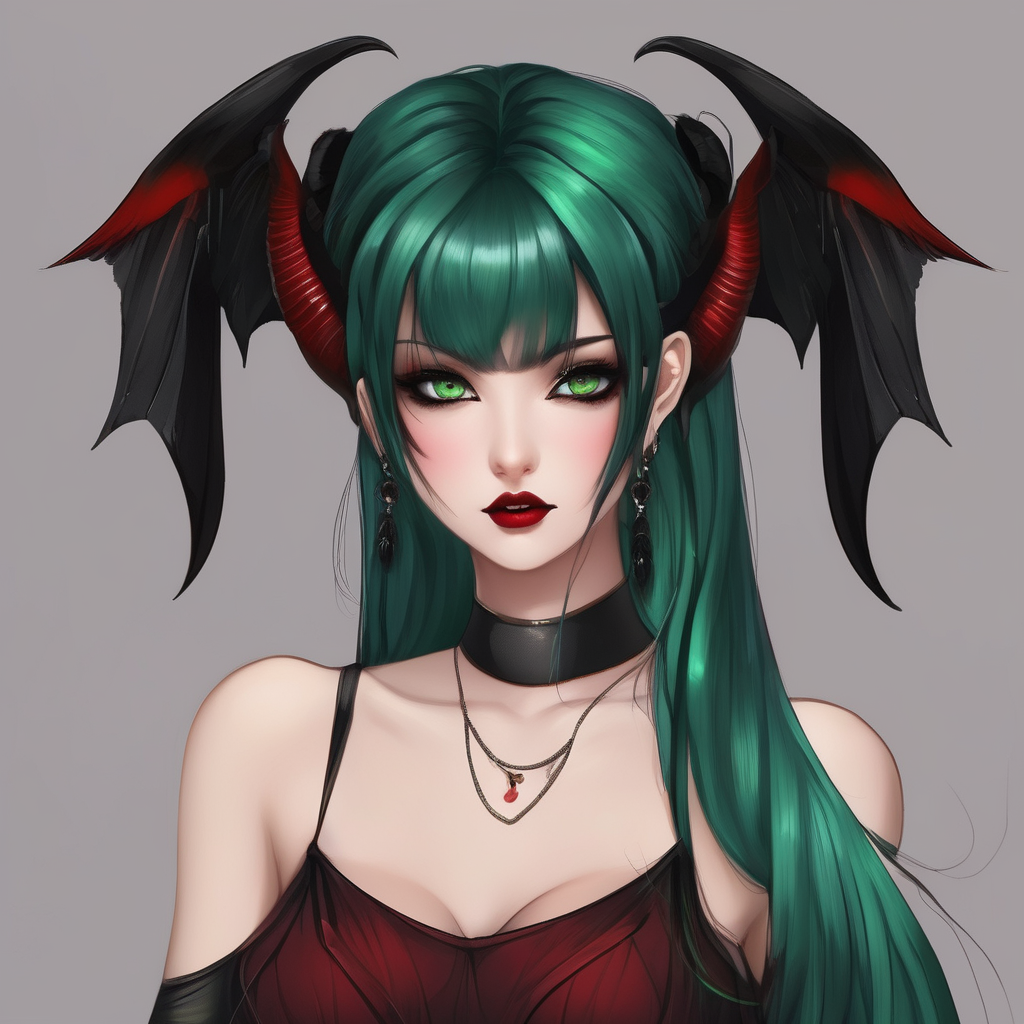

In [10]:
prompt = "long straight black hair, green eyes, dark wings on her back, small red horns on her head, dark red lipstick"
negative_prompt = "blurry, low resolution, distorted anatomy, extra limbs, deformed face, watermark, text"

# Генерація зображення
print(f"Генеруємо зображення для запиту: '{prompt}'...")
image = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt
).images[0]

# Відображення згенерованого зображення
print("Done.")
image

## Image-to-Image

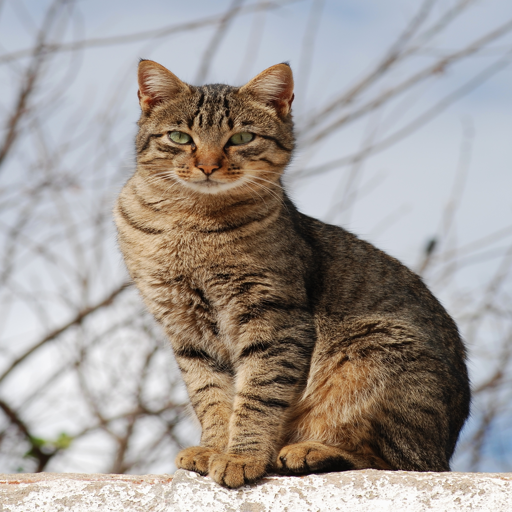

In [11]:
# Load initial image
init_image = Image.open("/content/cat.jpg").convert("RGB")
init_image = init_image.resize((512, 512))

init_image

In [ ]:
pipe = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/sdxl-turbo"
)
pipe = pipe.to("cuda")

  0%|          | 0/15 [00:00<?, ?it/s]

Done.


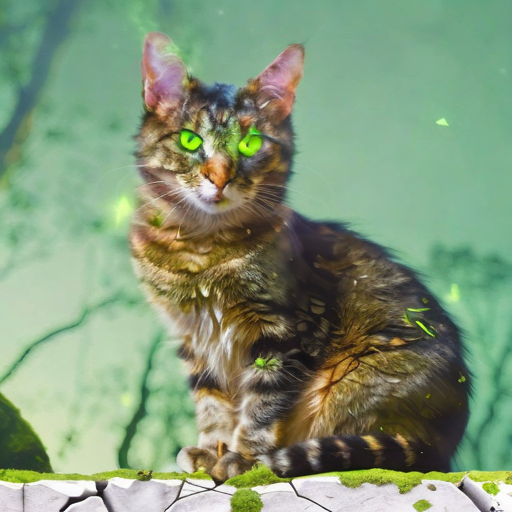

In [13]:
# Text prompt
prompt = "mystical cat with glowing green eyes, faint glowing runes on fur, sitting on ancient mossy ruins, magical forest background, fireflies, ethereal atmosphere, fantasy art"

# Generate image
image = pipe(prompt=prompt, image=init_image).images[0]

print("Done.")

image

##  Inpainting

In [14]:
img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png"
mask_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png"

target_size = (1024, 1024)
init_image = load_image(img_url).resize(target_size)
mask_image = load_image(mask_url).resize(target_size)

Initial Image vs Mask Image:


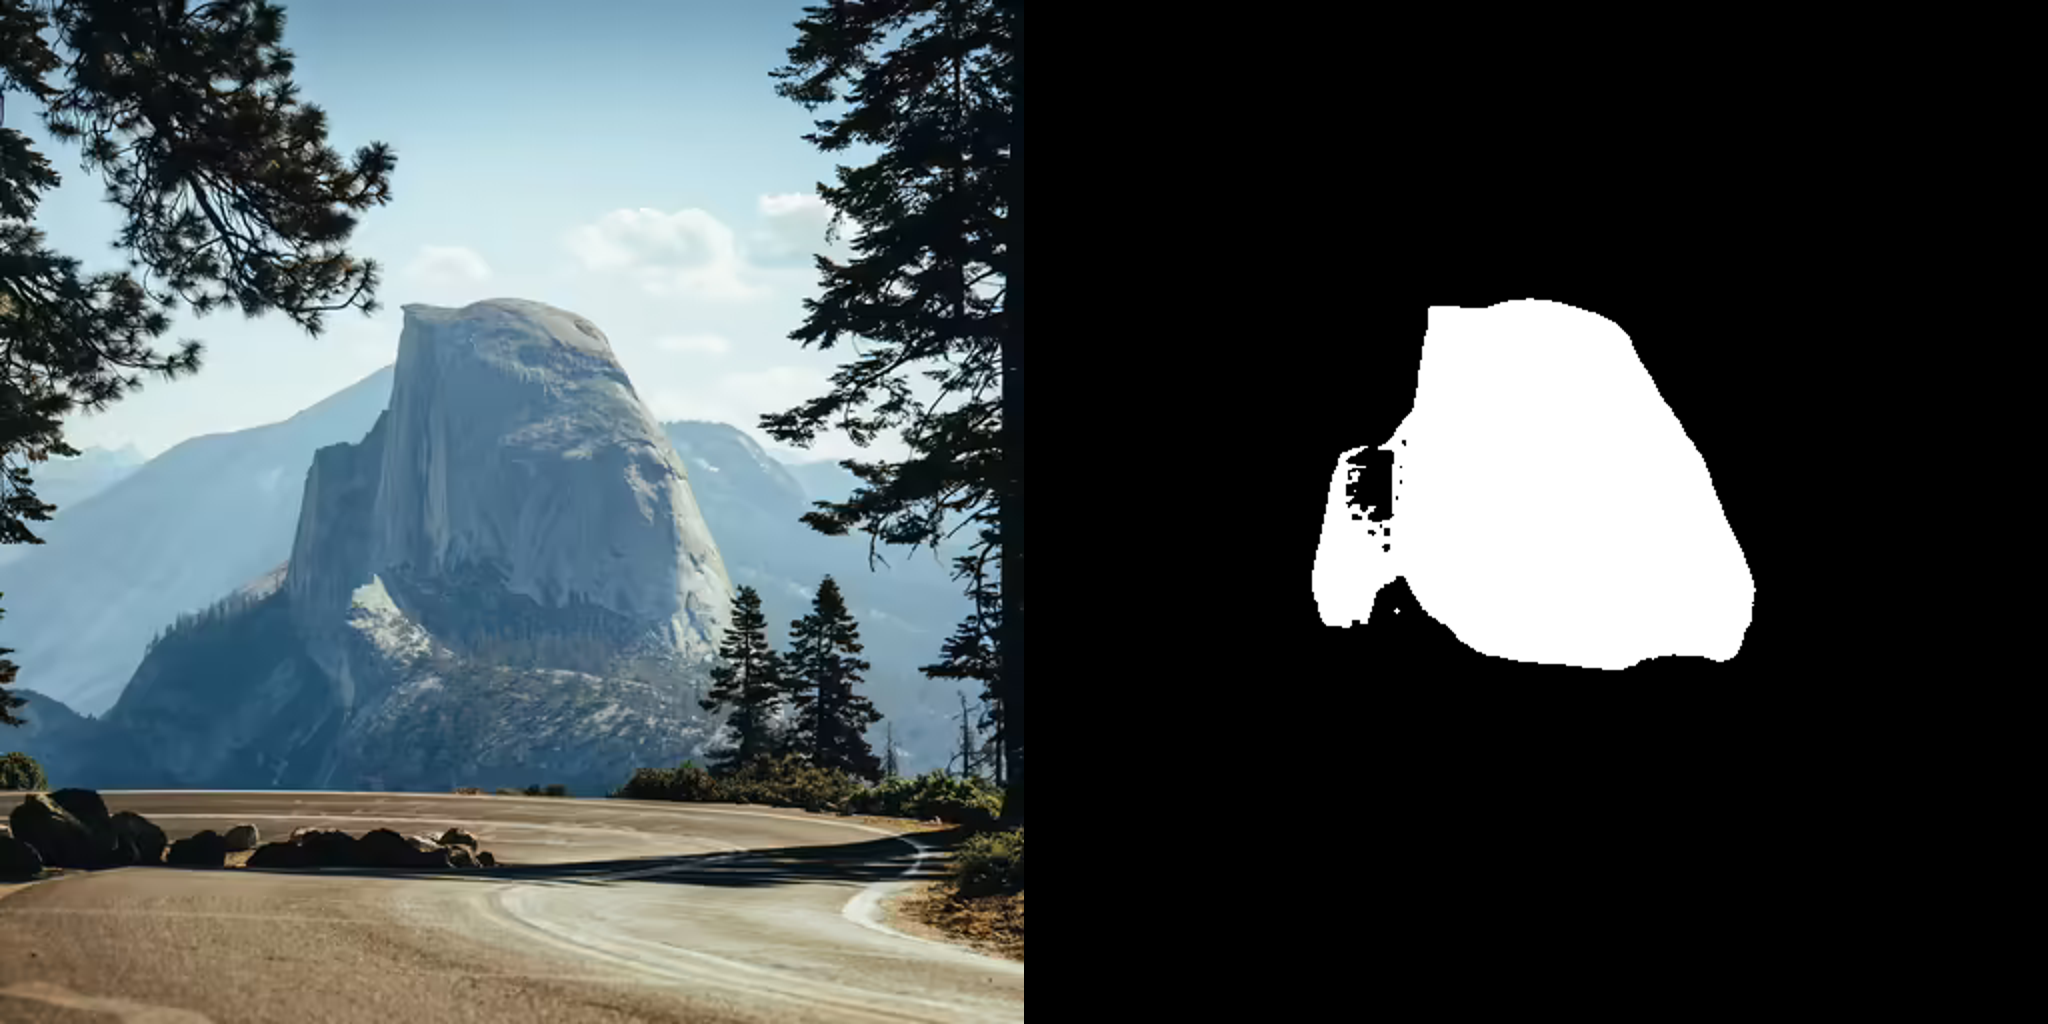

In [15]:
print("Initial Image vs Mask Image:")
display_img = Image.new('RGB', (target_size[0]*2, target_size[1]))
display_img.paste(init_image, (0,0))
display_img.paste(mask_image, (target_size[0],0))
display(display_img)

In [ ]:
pipe = AutoPipelineForInpainting.from_pretrained(
    "stabilityai/sdxl-turbo",
    variant="fp16"
)
pipe = pipe.to('cuda')

  0%|          | 0/49 [00:00<?, ?it/s]

Done.


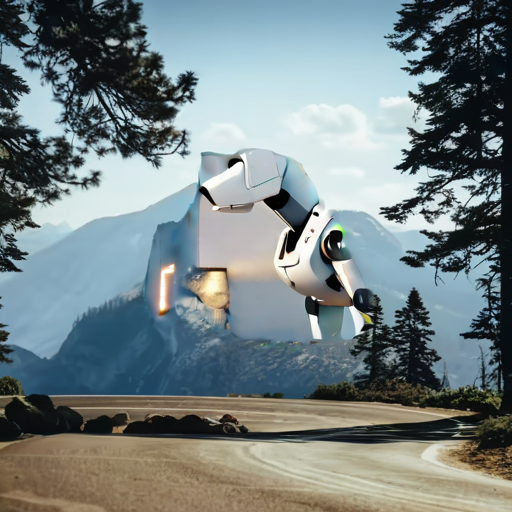

In [17]:
prompt = "a futuristic white robot dog sitting on a rock bench, high resolution, cinematic lighting"

image = pipe(
    prompt=prompt,
    image=init_image,
    mask_image=mask_image,
).images[0]

print("Done.")

image